# 

In [39]:
import pandas as pd

dataset = pd.read_csv('dataset.csv')

dataset.head()

,id,matchid,teamid,player,championid,position,kills,deaths,assists,killingsprees,...,win,goldearned,champlvl,totheal,totdmgtaken,towerkills,inhibkills_y,baronkills,dragonkills,harrykills
0,10,10,100,2,267,SUPP,0,2,12,0,...,0,9496,14,11707,17769,5,0,0,0,0
1,11,10,100,3,119,ADC,7,8,5,1,...,0,13136,14,2283,25627,5,0,0,0,0
2,17,10,200,9,222,ADC,15,3,9,2,...,1,15970,16,2802,17655,10,3,1,3,1
3,18,10,200,10,161,SUPP,4,5,19,1,...,1,12978,16,3242,13443,10,3,1,3,1
4,19,11,100,1,115,SUPP,2,7,5,0,...,0,7792,12,104,11576,2,0,0,0,0


In [41]:
# Add a KDA column where KDA = (kills + assists) / deaths
# Handle cases where deaths are 0 to avoid division by zero
dataset['KDA'] = (dataset['kills'] + dataset['assists']) / dataset['deaths'].replace(0, 1)

# Drop the kills, deaths, and assists columns
dataset = dataset.drop(columns=['kills', 'deaths', 'assists'])

# Save the updated dataset to a CSV file for inspection
dataset.to_csv("updated_dataset_with_kda.csv", index=False)

# Display the first few rows of the updated dataset
print(dataset.head())


   id  matchid  teamid  player  championid position  killingsprees  \
0  10       10     100       2         267     SUPP              0   
1  11       10     100       3         119      ADC              1   
2  17       10     200       9         222      ADC              2   
3  18       10     200      10         161     SUPP              1   
4  19       11     100       1         115     SUPP              0   

   totdmgdealt  visionscore  win  goldearned  champlvl  totheal  totdmgtaken  \
0        25995           30    0        9496        14    11707        17769   
1       171568           26    0       13136        14     2283        25627   
2       182680           12    1       15970        16     2802        17655   
3        85785           71    1       12978        16     3242        13443   
4        46790           26    0        7792        12      104        11576   

   towerkills  inhibkills_y  baronkills  dragonkills  harrykills  KDA  
0           5             

In [43]:
from sklearn.preprocessing import MinMaxScaler

# Define ID-related columns that should not be normalized
id_columns = ['id', 'matchid', 'teamid', 'player', 'championid']  # Adjust this list based on your dataset

# Select numeric columns excluding ID-related columns
numeric_columns_to_normalize = dataset.select_dtypes(include=['int64', 'float64']).columns.difference(id_columns)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization only to non-ID numeric columns
dataset[numeric_columns_to_normalize] = scaler.fit_transform(dataset[numeric_columns_to_normalize])

# Save the updated dataset to a CSV file for inspection
dataset.to_csv("normalized_dataset_with_kda_excluding_ids.csv", index=False)

# Display the first few rows of the updated dataset
print(dataset.head())


   id  matchid  teamid  player  championid position  killingsprees  \
0  10       10     100       2         267     SUPP       0.000000   
1  11       10     100       3         119      ADC       0.090909   
2  17       10     200       9         222      ADC       0.181818   
3  18       10     200      10         161     SUPP       0.090909   
4  19       11     100       1         115     SUPP       0.000000   

   totdmgdealt  visionscore  win  goldearned  champlvl   totheal  totdmgtaken  \
0     0.999612     0.167598  0.0    0.216474  0.764706  0.118057     0.152240   
1     0.999680     0.145251  0.0    0.322498  0.764706  0.023022     0.219565   
2     0.999685     0.067039  1.0    0.405045  0.882353  0.028256     0.151263   
3     0.999640     0.396648  1.0    0.317896  0.882353  0.032693     0.115176   
4     0.999622     0.145251  0.0    0.166841  0.647059  0.001049     0.099180   

   towerkills  inhibkills_y  baronkills  dragonkills  harrykills       KDA  
0      0.3125  

In [8]:
dataset.dtypes

id                 int64
matchid            int64
teamid             int64
player             int64
championid         int64
position          object
killingsprees    float64
totdmgdealt      float64
visionscore      float64
win              float64
goldearned       float64
champlvl         float64
totheal          float64
totdmgtaken      float64
towerkills       float64
inhibkills_y     float64
baronkills       float64
dragonkills      float64
harrykills       float64
KDA              float64
dtype: object

In [10]:
dataset = dataset.drop(columns=['baronkills','inhibkills_y','dragonkills','harrykills','towerkills'])
dataset.dtypes

id                 int64
matchid            int64
teamid             int64
player             int64
championid         int64
position          object
killingsprees    float64
totdmgdealt      float64
visionscore      float64
win              float64
goldearned       float64
champlvl         float64
totheal          float64
totdmgtaken      float64
KDA              float64
dtype: object

In [45]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Step 1: Create ADC-Support Pair Dataset
adc_rows = dataset[dataset['position'] == 'ADC']
support_rows = dataset[dataset['position'] == 'SUPP']

# Merge ADC rows with corresponding Support rows
adc_with_support = pd.merge(
    adc_rows,
    support_rows[['matchid', 'teamid', 'championid']],
    on=['matchid', 'teamid'],
    suffixes=('', '_support')
)

# Rename the support champion column
adc_with_support.rename(columns={'championid_support': 'support_champion'}, inplace=True)

# Drop unnecessary columns
adc_with_support = adc_with_support.drop(columns=['id', 'player', 'position'])

# Display the processed dataset
print(adc_with_support.head())

# Step 2: Prepare Data for SVD
# Create a matrix where rows are ADCs, columns are Supports, and values are win rates (or another metric)
matrix = adc_with_support.pivot_table(
    index='championid', 
    columns='support_champion', 
    values='win', 
    aggfunc='mean'
).fillna(0)

# Step 3: Perform SVD
svd = TruncatedSVD(n_components=10, random_state=42)
latent_factors = svd.fit_transform(matrix)

# Step 4: Make Recommendations
# Compute the predicted values by reconstructing the matrix
predicted_matrix = np.dot(latent_factors, svd.components_)

# Convert predictions back to DataFrame
predicted_df = pd.DataFrame(predicted_matrix, index=matrix.index, columns=matrix.columns)

# Step 5: Recommend Top Support Champions for Each ADC
def recommend_supports(adc_id, top_n=5):
    if adc_id not in predicted_df.index:
        return f"ADC {adc_id} not found in the dataset."
    recommendations = predicted_df.loc[adc_id].sort_values(ascending=False).head(top_n)
    return recommendations

# Example: Get top 5 recommended supports for a specific ADC
example_adc_id = adc_with_support['championid'].iloc[0]  # Replace with your ADC ID
recommendations = recommend_supports(example_adc_id)
print("champion id: ",example_adc_id)
# Display the recommendations
recommendations


   matchid  teamid  championid  killingsprees  totdmgdealt  visionscore  win  \
0       10     100         119       0.090909     0.999680     0.145251  0.0   
1       10     200         222       0.181818     0.999685     0.067039  1.0   
2       11     100          69       0.000000     0.999629     0.089385  0.0   
3       11     200          51       0.272727     0.999676     0.100559  1.0   
4       12     100         119       0.090909     0.999635     0.022346  0.0   

   goldearned  champlvl   totheal  totdmgtaken  towerkills  inhibkills_y  \
0    0.322498  0.764706  0.023022     0.219565      0.3125      0.000000   
1    0.405045  0.882353  0.028256     0.151263      0.6250      0.230769   
2    0.188745  0.647059  0.030283     0.141976      0.1250      0.000000   
3    0.347052  0.823529  0.035789     0.165580      0.6250      0.230769   
4    0.194192  0.588235  0.022972     0.154493      0.0625      0.000000   

   baronkills  dragonkills  harrykills       KDA  support_cham

support_champion
60     0.942070
432    0.892673
69     0.886181
75     0.835467
59     0.832444
Name: 119, dtype: float64

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Step 1: Create ADC-Support Pair Dataset
adc_rows = dataset[dataset['position'] == 'ADC']
support_rows = dataset[dataset['position'] == 'SUPP']

# Merge ADC rows with corresponding Support rows
adc_with_support = pd.merge(
    adc_rows,
    support_rows[['matchid', 'teamid', 'championid']],
    on=['matchid', 'teamid'],
    suffixes=('', '_support')
)

# Rename the support champion column
adc_with_support.rename(columns={'championid_support': 'support_champion'}, inplace=True)

# Drop unnecessary columns
adc_with_support = adc_with_support.drop(columns=['id', 'player', 'position'])

# Step 2: Feature Selection
# Define features (X) and target (y)
X = adc_with_support.drop(columns=['support_champion', 'matchid', 'teamid'])
y = adc_with_support['support_champion']

# # Step 3: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 5: Evaluate the Model
y_pred = model.predict(X_test)

# Step 6: Recommend Supports
def recommend_supports_for_adc(adc_features, model, top_n=5):
    probabilities = model.predict_proba([adc_features])[0]
    support_champion_indices = probabilities.argsort()[-top_n:][::-1]
    support_champion_ids = model.classes_[support_champion_indices]
    recommendations = {support_id: probabilities[idx] for support_id, idx in zip(support_champion_ids, support_champion_indices)}
    return recommendations

In [10]:
adc_with_support.head()

,matchid,teamid,championid,killingsprees,totdmgdealt,visionscore,win,goldearned,champlvl,totheal,totdmgtaken,KDA,support_champion
0,10,100,119,0.090909,0.999680,0.145251,0.0,0.322498,0.764706,0.023022,0.219565,0.031250,267
1,10,200,222,0.181818,0.999685,0.067039,1.0,0.405045,0.882353,0.028256,0.151263,0.166667,161
2,11,100,69,0.000000,0.999629,0.089385,0.0,0.188745,0.647059,0.030283,0.141976,0.020833,115
3,11,200,51,0.272727,0.999676,0.100559,1.0,0.347052,0.823529,0.035789,0.165580,0.066667,43
4,12,100,119,0.090909,0.999635,0.022346,0.0,0.194192,0.588235,0.022972,0.154493,0.023438,40


In [17]:
winrate_data_path = 'adc_support_duos_with_winrate.csv'
winrate_data = pd.read_csv(winrate_data_path)


# Step 4: Prepare Recommendations and Compare with Winrates
test_set_with_predictions = X_test.copy()
test_set_with_predictions['predicted_support'] = y_pred
test_set_with_predictions['adc_champion'] = X_test['championid']  # Assuming `championid` is the ADC column

# Update the merge to use the correct column names
test_set_with_predictions = test_set_with_predictions.merge(
    winrate_data[['ADC', 'Support', 'Winrate']],
    left_on=['adc_champion', 'predicted_support'],
    right_on=['ADC', 'Support'],
    how='left'
)

# Calculate the average win rate of the recommendations
average_winrate = test_set_with_predictions['Winrate'].mean()

# Output the result
print(f"Average Win Rate of Recommended Duos: {average_winrate:.2%}")


NameError: name 'X_test' is not defined

In [19]:
print(winrate_data.columns)


Index(['ADC', 'Support', 'Wins', 'Total Games', 'Winrate'], dtype='object')


In [21]:
X_test

NameError: name 'X_test' is not defined

In [195]:
X_test.iloc[0]

championid       51.000000
killingsprees     0.181818
totdmgdealt       0.999779
visionscore       0.162011
win               0.000000
goldearned        0.533089
champlvl          1.000000
totheal           0.038099
totdmgtaken       0.144358
KDA               0.180556
Name: 278448, dtype: float64

In [196]:
y_test.iloc[0]

53

In [197]:
copy = X_test.head(1)
copy

,championid,killingsprees,totdmgdealt,visionscore,win,goldearned,champlvl,totheal,totdmgtaken,KDA
278448,51,0.181818,0.999779,0.162011,0.0,0.533089,1.0,0.038099,0.144358,0.180556


In [198]:
copy['championid'] = 51
copy

/var/folders/81/1wd_67mn24l93zgmtg8zy2b40000gn/T/ipykernel_94878/4058370486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['championid'] = 51


,championid,killingsprees,totdmgdealt,visionscore,win,goldearned,champlvl,totheal,totdmgtaken,KDA
278448,51,0.181818,0.999779,0.162011,0.0,0.533089,1.0,0.038099,0.144358,0.180556


In [199]:
copy_pred = model.predict(copy)
copy_pred

array([43])

In [200]:
y_pred

array([ 43, 412, 412, ..., 412, 117, 412])

In [201]:
dataset

,id,matchid,teamid,player,championid,position,killingsprees,totdmgdealt,visionscore,win,goldearned,champlvl,totheal,totdmgtaken,KDA
0,10,10,100,2,267,SUPP,0.000000,0.999612,0.167598,0.0,0.216474,0.764706,0.118057,0.152240,0.125000
1,11,10,100,3,119,ADC,0.090909,0.999680,0.145251,0.0,0.322498,0.764706,0.023022,0.219565,0.031250
2,17,10,200,9,222,ADC,0.181818,0.999685,0.067039,1.0,0.405045,0.882353,0.028256,0.151263,0.166667
3,18,10,200,10,161,SUPP,0.090909,0.999640,0.396648,1.0,0.317896,0.882353,0.032693,0.115176,0.095833
4,19,11,100,1,115,SUPP,0.000000,0.999622,0.145251,0.0,0.166841,0.647059,0.001049,0.099180,0.020833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678138,1865593,187587,200,9,37,SUPP,0.090909,0.999610,0.000000,0.0,0.247728,0.882353,0.136158,0.210638,0.034722
678139,1865596,187588,100,2,18,ADC,0.363636,0.999703,0.000000,1.0,0.405016,1.000000,0.012908,0.217209,0.072917
678140,1865599,187588,100,5,25,SUPP,0.181818,0.999629,0.000000,1.0,0.390598,1.000000,0.016659,0.134702,0.312500
678141,1865600,187588,200,6,222,ADC,0.272727,0.999727,0.000000,0.0,0.417948,1.000000,0.037524,0.258917,0.027083


In [202]:
adc_with_support.dtypes

matchid               int64
teamid                int64
championid            int64
killingsprees       float64
totdmgdealt         float64
visionscore         float64
win                 float64
goldearned          float64
champlvl            float64
totheal             float64
totdmgtaken         float64
KDA                 float64
support_champion      int64
dtype: object

In [85]:
# Step 1: Calculate medians for all numeric columns grouped by `championid`
median_values_by_champion = adc_with_support.groupby('championid').median().reset_index()

# Step 2: Calculate the overall median for all numeric columns
overall_medians = adc_with_support.median()

# Step 3: Add a row for missing champions with the overall medians
def ensure_champion_medians(champion_id, median_df, overall_medians):
    """
    Ensure that every champion has a median value. If a champion is missing, fill it with overall medians.

    Parameters:
        champion_id (int): The champion ID to check.
        median_df (DataFrame): DataFrame containing medians by champion.
        overall_medians (Series): Series containing overall median values.

    Returns:
        DataFrame: Updated DataFrame with missing champion filled.
    """
    if champion_id not in median_df['championid'].values:
        # Create a new row with overall medians and the missing champion_id
        new_row = overall_medians.to_dict()
        new_row['championid'] = champion_id
        return pd.concat([median_df, pd.DataFrame([new_row])], ignore_index=True)
    return median_df

# Example: Ensure that a specific champion ID is present
example_champion_id = 516  # Replace with your champion ID
median_values_by_champion = ensure_champion_medians(example_champion_id, median_values_by_champion, overall_medians)

# Display the resulting DataFrame
print(median_values_by_champion)

# Optionally, save the result to a CSV file for future use
median_values_by_champion.to_csv('median_values_by_champion.csv', index=False)


     championid   matchid  teamid  killingsprees  totdmgdealt  visionscore  \
0             1   93423.0   100.0       0.181818     0.999655     0.033520   
1             2  111819.0   100.0       0.272727     0.999662     0.022346   
2             3  147529.0   100.0       0.090909     0.999653     0.067039   
3             4   89667.0   200.0       0.090909     0.999659     0.033520   
4             5  128927.0   200.0       0.181818     0.999650     0.083799   
..          ...       ...     ...            ...          ...          ...   
120         429   97188.0   100.0       0.181818     0.999663     0.027933   
121         432  102658.0   200.0       0.090909     0.999655     0.044693   
122         497   73862.5   150.0       0.090909     0.999622     0.030726   
123         498   88712.0   200.0       0.181818     0.999666     0.044693   
124         516   93835.5   100.0       0.181818     0.999664     0.044693   

     win  goldearned  champlvl   totheal  totdmgtaken  towerkil

In [150]:
# Calculate means for all numeric columns grouped by `championid`
mean_values_by_champion = adc_with_support.groupby('championid').mean().reset_index()

# Display the resulting DataFrame
print(mean_values_by_champion)

# Optionally, save the result to a CSV file for future use
mean_values_by_champion.to_csv('mean_values_by_champion.csv', index=False)

     championid        matchid      teamid  killingsprees  totdmgdealt  \
0             1  102665.367347  142.857143       0.166976     0.999658   
1             2  107445.600000  140.000000       0.236364     0.999670   
2             3  117839.600000  140.000000       0.090909     0.999661   
3             4   89876.092784  152.577320       0.148079     0.999666   
4             5  101639.333333  166.666667       0.181818     0.999652   
..          ...            ...         ...            ...          ...   
119         420  104535.400000  120.000000       0.054545     0.999660   
120         429   96182.784288  149.261484       0.169202     0.999667   
121         432  101988.717949  151.282051       0.121212     0.999653   
122         497   73862.500000  150.000000       0.090909     0.999622   
123         498   92016.781339  150.486906       0.156212     0.999672   

     visionscore       win  goldearned  champlvl   totheal  totdmgtaken  \
0       0.052674  0.632653    0.3198

In [151]:
# Calculate maxes for all numeric columns grouped by `championid`
max_values_by_champion = adc_with_support.groupby('championid').max().reset_index()

# Display the resulting DataFrame
print(max_values_by_champion)

# Optionally, save the result to a CSV file for future use
max_values_by_champion.to_csv('max_values_by_champion.csv', index=False)

     championid  matchid  teamid  killingsprees  totdmgdealt  visionscore  \
0             1   185567     200       0.454545     0.999723     0.201117   
1             2   152417     200       0.363636     0.999711     0.145251   
2             3   178712     200       0.181818     0.999691     0.162011   
3             4   185851     200       0.545455     0.999798     0.217877   
4             5   142662     200       0.272727     0.999660     0.094972   
..          ...      ...     ...            ...          ...          ...   
119         420   176799     200       0.090909     0.999673     0.167598   
120         429   187526     200       0.909091     0.999852     0.469274   
121         432   186161     200       0.454545     0.999753     0.240223   
122         497   135132     200       0.181818     0.999637     0.055866   
123         498   187253     200       0.818182     0.999901     0.586592   

     win  goldearned  champlvl   totheal  totdmgtaken  towerkills  \
0    1

In [49]:
X_test = median_values_by_champion.drop(columns = ['support_champion','matchid','teamid'])
y_test = median_values_by_champion['support_champion']
print(len(X_test.iloc[0]))

15


In [33]:
y_pred = model.predict(X_test)

winrate_data_path = 'adc_support_duos_with_winrate.csv'
winrate_data = pd.read_csv(winrate_data_path)

# Step 4: Prepare Recommendations and Compare with Winrates
test_set_with_predictions = X_test.copy()
test_set_with_predictions['predicted_support'] = y_pred
test_set_with_predictions['adc_champion'] = X_test['championid']  # Assuming `championid` is the ADC column

# Update the merge to use the correct column names
test_set_with_predictions = test_set_with_predictions.merge(
    winrate_data[['ADC', 'Support', 'Winrate']],
    left_on=['adc_champion', 'predicted_support'],
    right_on=['ADC', 'Support'],
    how='left'
)

# Calculate the average win rate of the recommendations
average_winrate = test_set_with_predictions['Winrate'].mean()

# Output the result
print(f"Average Win Rate of Recommended Duos: {average_winrate:.2%}")

Average Win Rate of Recommended Duos: 51.05%


In [22]:
champs = pd.read_csv("/Users/froguro/.cache/kagglehub/datasets/paololol/league-of-legends-ranked-matches/versions/9/champs.csv")
champion_id_to_name = dict(zip(champs['id'], champs['name']))


In [50]:
def recommend_support(adc_id):
    return model.predict(median_values_by_champion.loc[median_values_by_champion['championid'] == adc_id].drop(columns=['support_champion','matchid','teamid']))


In [87]:
adc_id = 516
res = recommend_support(adc_id)
print(res)

def recommend_supports_for_adc(adc_features, model, champion_id_to_name, top_n=5):
    """
    Recommend the most likely Supports for a given ADC based on probabilities, returning champion names.
    
    Parameters:
        adc_features (array-like): Features of the ADC champion for prediction.
        model (sklearn model): Trained classification model.
        champion_id_to_name (dict): Mapping of champion IDs to their names.
        top_n (int): Number of top recommendations to return.
    
    Returns:
        dict: Recommended Support champion names with probabilities.
    """
    # Get predicted probabilities for each Support champion
    probabilities = model.predict_proba([adc_features])[0]
    
    # Get indices of the top N probabilities
    support_champion_indices = probabilities.argsort()[-top_n:][::-1]
    
    # Map indices to Support champion IDs
    support_champion_ids = model.classes_[support_champion_indices]
    
    # Map champion IDs to names and probabilities
    recommendations = {
        champion_id_to_name.get(support_id, f"Unknown ID {support_id}"): probabilities[idx]
        for support_id, idx in zip(support_champion_ids, support_champion_indices)
    }
    
    return recommendations

adc_features = median_values_by_champion.loc[median_values_by_champion['championid'] == adc_id].drop(columns=['support_champion','matchid','teamid']).iloc[0]
recommendations = recommend_supports_for_adc(adc_features, model, champion_id_to_name)
print(f"Top Support recommendations for ADC {champion_id_to_name.get(adc_id)}")
for champion_name, probability in recommendations.items():
    print(f"{champion_name}: {probability:.4f}")

# res = recommend_supports_for_adc(adc_features, model)
# print(res)

[497]
Top Support recommendations for ADC Ornn
Rakan: 0.2300
Brand: 0.0900
Karma: 0.0900
Nami: 0.0900
Morgana: 0.0600


/Users/froguro/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [63]:
for champ in median_values_by_champion.championid:
    res = recommend_support(champ)
    print(champion_id_to_name[champ], ": ", champion_id_to_name[res[0]], winrate_data[(winrate_data['ADC']==champ) & (winrate_data['Support']==res[0])].Winrate)

Annie :  Thresh 1119    1.0
Name: Winrate, dtype: float64
Olaf :  Soraka Series([], Name: Winrate, dtype: float64)
Galio :  Brand Series([], Name: Winrate, dtype: float64)
Twisted Fate :  Blitzcrank 1139    0.3
Name: Winrate, dtype: float64
Xin Zhao :  Soraka Series([], Name: Winrate, dtype: float64)
Urgot :  Thresh 848    0.4
Name: Winrate, dtype: float64
LeBlanc :  Thresh 2482    0.5
Name: Winrate, dtype: float64
Vladimir :  Soraka Series([], Name: Winrate, dtype: float64)
Fiddlesticks :  Thresh 2620    1.0
Name: Winrate, dtype: float64
Kayle :  Lulu 2413    1.0
Name: Winrate, dtype: float64
Master Yi :  Thresh Series([], Name: Winrate, dtype: float64)
Alistar :  Thresh 960    0.0
Name: Winrate, dtype: float64
Ryze :  Rakan Series([], Name: Winrate, dtype: float64)
Sion :  Thresh Series([], Name: Winrate, dtype: float64)
Sivir :  Thresh 224    0.486772
Name: Winrate, dtype: float64
Soraka :  Thresh 1454    1.0
Name: Winrate, dtype: float64
Teemo :  Thresh 1042    0.612903
Name: Winra

In [110]:
winrate_data

,ADC,Support,Wins,Total Games,Winrate
0,119,267,511,967,0.528438
1,222,161,115,228,0.504386
2,69,115,0,1,0.000000
3,51,43,1794,3555,0.504641
4,119,40,961,1744,0.551032
...,...,...,...,...,...
2930,110,91,0,1,0.000000
2931,76,25,0,1,0.000000
2932,25,21,0,1,0.000000
2933,203,40,1,1,1.000000


In [39]:
test_set_with_predictions['Winrate']

0      1.000000
1           NaN
2           NaN
3      0.608696
4           NaN
         ...   
119         NaN
120    0.521841
121    0.750000
122         NaN
123    0.478925
Name: Winrate, Length: 124, dtype: float64

         Feature  Importance
8    totdmgtaken    0.158787
7        totheal    0.157334
5     goldearned    0.156466
2    totdmgdealt    0.148640
9            KDA    0.131852
3    visionscore    0.081534
0     championid    0.081002
6       champlvl    0.039340
1  killingsprees    0.034298
4            win    0.010747


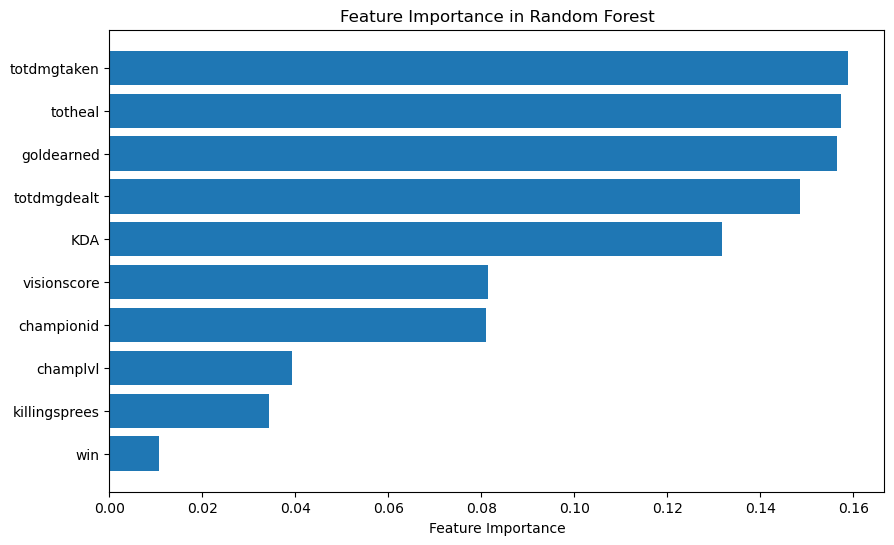

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance from the trained model
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance)

# Visualize the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.savefig('feature_importances.png')
plt.show()


In [80]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD

# Load the dataset
winrate_data = pd.read_csv('adc_support_duos_with_winrate.csv')

# Create the ADC-Support matrix
duo_matrix = winrate_data.pivot(index='ADC', columns='Support', values='Winrate').fillna(0)

# Apply SVD
svd = TruncatedSVD(n_components=10, random_state=42)
latent_factors = svd.fit_transform(duo_matrix)

# Analyze explained variance
explained_variance_ratio = svd.explained_variance_ratio_

# Create a DataFrame for explained variance
svd_results = pd.DataFrame({
    "Component": range(1, len(explained_variance_ratio) + 1),
    "Explained Variance Ratio": explained_variance_ratio
})

# Save or display the results
print(svd_results)

# Optionally save results to a CSV for further analysis
# svd_results.to_csv('svd_explained_variance_ratio.csv', index=False)


   Component  Explained Variance Ratio
0          1                  0.348479
1          2                  0.062361
2          3                  0.031672
3          4                  0.025036
4          5                  0.024190
5          6                  0.022547
6          7                  0.021420
7          8                  0.020913
8          9                  0.019374
9         10                  0.018313


In [82]:
import numpy as np

# Define a function to recommend supports or find similar champions
def recommend_supports_or_similar_champions(adc_id, svd_model, matrix, top_n=5):
    """
    Recommend top supports for an ADC or find similar champions based on SVD.

    Parameters:
        adc_id (int): The ID of the ADC champion to test.
        svd_model (TruncatedSVD): The trained SVD model.
        matrix (DataFrame): The ADC-Support matrix.
        top_n (int): Number of top recommendations or similar champions to return.

    Returns:
        dict: Recommended supports or similar champions with scores.
    """
    if adc_id not in matrix.index:
        return f"Champion ID {adc_id} not found in the matrix."

    # Get the row corresponding to the ADC
    adc_idx = matrix.index.get_loc(adc_id)
    latent_factors = svd_model.transform(matrix)  # Recalculate projections

    # Calculate scores for all supports based on the ADC's latent factors
    predictions = np.dot(latent_factors[adc_idx], svd_model.components_)

    # Rank supports by scores
    recommended_indices = np.argsort(-predictions)[:top_n]
    support_ids = matrix.columns[recommended_indices]
    scores = predictions[recommended_indices]

    # Return the top recommendations as a dictionary
    return dict(zip(support_ids, scores))

# Example: Test a specific ADC champion
test_adc_id = 119  # Replace with your ADC ID
recommendations = recommend_supports_or_similar_champions(test_adc_id, svd, duo_matrix)
print(f"Recommendations for ADC {test_adc_id}:\n", recommendations)


Recommendations for ADC 119:
 {60: 0.9509357836097169, 69: 0.8930552462134018, 432: 0.8865565447195238, 238: 0.8414541627147818, 75: 0.8398024579206949}


championid       119.000000
killingsprees      0.181818
totdmgdealt        0.999667
visionscore        0.044693
win                1.000000
goldearned         0.337513
champlvl           0.764706
totheal            0.032577
totdmgtaken        0.175506
towerkills         0.437500
inhibkills_y       0.076923
baronkills         0.000000
dragonkills        0.142857
harrykills         0.000000
KDA                0.046296
Name: 91, dtype: float64